In [1]:
import numpy as np
import matplotlib.pyplot as plt

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel

from pyHalo.single_realization import SingleHalo
from pyHalo.Halos.lens_cosmo import LensCosmo

### First, create a lens model that we can use to simulate a lensed image

In [2]:
zlens, zsource = 0.5, 2.0
lens_cosmo = LensCosmo(zlens, zsource)
lens_model_list_macro = ['EPL', 'SHEAR']
lens_redshift_list_macro = [zlens, zlens]
lens_model = LensModel(lens_model_list_macro, lens_redshift_list=lens_redshift_list_macro, multi_plane=True, z_source=zsource)
light_model = LightModel(['GAUSSIAN'])
kwargs_macromodel = [{'theta_E': 1.0, 'center_x': 0.0, 'center_y': 0.0, 'e1': 0.23, 'e2': -0.1, 'gamma': 2.0}, 
                    {'gamma1': 0.04, 'gamma2': -0.02}]
image_x, image_y = 1.4, 0.0
source_x, source_y = lens_model.ray_shooting(image_x, image_y, kwargs_macromodel)

source_size_parsec = 40.0
kpc_per_arcsec_zsource = 8.5
parsec_to_arcsec = 0.001 / kpc_per_arcsec_zsource
source_size_arcsec = source_size_parsec * parsec_to_arcsec
kwargs_lightmodel = [{'amp': 1.0, 'center_x': source_x, 'center_y': source_y, 'sigma': source_size_arcsec}]

### Thi cell ray traces through the lens model to create the image and calculate the magnification. 

So far, there are no halos in the model. The "macromodel" here is just the galaxy making the strong lens system. 

6.922732917116802


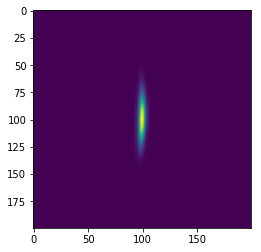

In [3]:
def create_image(x, y, lensmodel, lightmodel, kwargs_lens, kwargs_light, npix=200, grid_size=0.2):
    _r = np.linspace(-grid_size, grid_size, npix)
    _xx, _yy = np.meshgrid(_r, _r)
    _shape = _xx.shape
    source_plane_x, source_plane_y = lensmodel.ray_shooting(_xx.ravel() + x, _yy.ravel() + y, kwargs_lens)
    image = lightmodel.surface_brightness(source_plane_x, source_plane_y, kwargs_light)
    magnification = np.sum(image) * (2*grid_size/npix)**2
    return image.reshape(_shape), magnification
    
image_nohalo, magnification_nohalo = create_image(image_x, image_y, lens_model, light_model, kwargs_macromodel, kwargs_lightmodel)
plt.imshow(image_nohalo)
print(magnification_nohalo)

### Now we can create a new lens model that includes a dark matter halo

In [4]:
halo_mass = 10 ** 8.
halo_x = image_x - 0.05
halo_y = image_y + 0.05
mass_definition = 'TNFW'
halo_redshift = zlens

single_halo = SingleHalo(halo_mass, halo_x, halo_y, mass_definition, halo_redshift, 
                         zlens, zsource, subhalo_flag=True, r3d=50.0, lens_cosmo=lens_cosmo)
lens_model_list_halo, halo_redshift_array, kwargs_halo, _ = single_halo.lensing_quantities()

lens_model_with_halo = LensModel(lens_model_list_macro+lens_model_list_halo, 
                                 lens_redshift_list=lens_redshift_list_macro+list(halo_redshift_array), 
                                z_source=zsource, multi_plane=True)
kwargs_with_halo = kwargs_macromodel + kwargs_halo

7.121856600618123
relative change in flux (%):  0.0


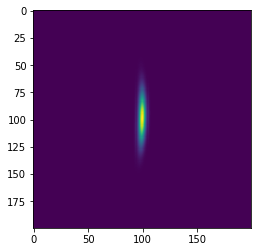

In [5]:
image_with_halo, magnification_with_halo = create_image(image_x, image_y, lens_model_with_halo, 
                                                        light_model, kwargs_with_halo, kwargs_lightmodel)
plt.imshow(image_with_halo)
print(magnification_with_halo)
print('relative change in flux (%): ', np.round(100*(1-magnification_with_halo/magnification_with_halo),2))

### A good way to quantify the effect of a halo is to compute the magnification cross section, or the change in flux as a function of the halo position

We use the functions defined in the previous cells, but just move the halo across the image in the x direction and record the brightness

1.3693554276829174
15.113655821606187


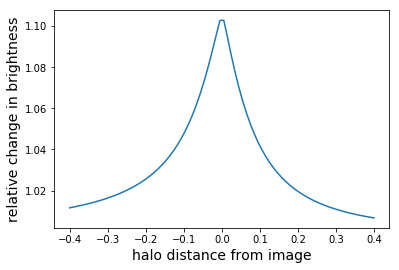

In [6]:
halo_offset = np.linspace(-0.4, 0.4, 80)

magnifications = []
for x_offset in halo_offset:
    halo_x = image_x - x_offset
    halo_y = image_y + 0.025
    halo_settings = {'c_scatter': False} # we turn off scatter in concentration-mass relation to remove extra randomness
    single_halo = SingleHalo(halo_mass, halo_x, halo_y, mass_definition, halo_redshift, 
                         zlens, zsource, lens_cosmo=lens_cosmo, kwargs_halo=halo_settings)
    _, _, halo_kwargs, _ = single_halo.lensing_quantities()
    # we only need the new keyword arguments for the halo, don't have to create the lens model class again
    kwargs_with_halo = kwargs_macromodel + halo_kwargs
    _, mag = create_image(image_x, image_y, lens_model_with_halo, 
                                                        light_model, kwargs_with_halo, kwargs_lightmodel)
    magnifications.append(mag)

# we only care about the relative change in flux
relative_flux = np.array(magnifications)/magnification_nohalo 

plt.plot(halo_offset, relative_flux)
plt.xlabel('halo distance from image', fontsize=14)
plt.ylabel('relative change in brightness', fontsize=14)

# this is a characteristic size or length scale associated with an NFW profile
halo_scale_radius = halo_kwargs[0]['Rs'] 
# this is the truncation radius
default_trunctation_radius = halo_kwargs[0]['r_trunc'] 
print(default_trunctation_radius) # units of arseconds, or an angle
print(default_trunctation_radius/halo_scale_radius)

### Change the truncation radius

The easiest way to change the tidal or truncation radius is to create the halo class, get the keyword arguments, and then change the trunation radius in the keywords

Text(0,0.5,'relative change in brightness')

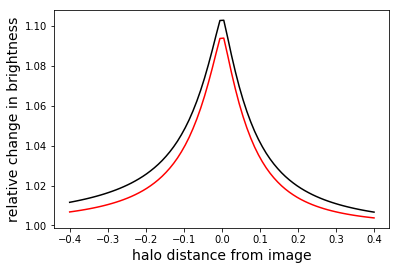

In [7]:
magnifications_new_truncation = []
for x_offset in halo_offset:
    
    # this is the same as before
    halo_x = image_x - x_offset
    halo_y = image_y + 0.025
    halo_settings = {'c_scatter': False} # we turn off scatter in concentration-mass relation to remove extra randomness
    single_halo = SingleHalo(halo_mass, halo_x, halo_y, mass_definition, halo_redshift, 
                         zlens, zsource, lens_cosmo=lens_cosmo, kwargs_halo=halo_settings)
    _, _, halo_kwargs, _ = single_halo.lensing_quantities()
    
    # now we change the keyword arguments
    # don't have to create the lens model class again because the lens model includes the same list of objects
    kwargs_with_halo = kwargs_macromodel + halo_kwargs
    
    halo_scale_radius = halo_kwargs[0]['Rs'] 
    
    # I suggest defining the truncation radius relative to scale radius
    new_trunctation_radius = halo_scale_radius * 3.0 
    
    # now change the truncation
    halo_kwargs[0]['r_trunc'] = new_trunctation_radius
    
    _, mag = create_image(image_x, image_y, lens_model_with_halo, 
                                                        light_model, kwargs_with_halo, kwargs_lightmodel)
    magnifications_new_truncation.append(mag)
    
relative_flux_new_truncation = np.array(magnifications_new_truncation)/magnification_nohalo # we only care about the relative change in flux
plt.plot(halo_offset, relative_flux, color='k')
plt.plot(halo_offset, relative_flux_new_truncation, color='r')
plt.xlabel('halo distance from image', fontsize=14)
plt.ylabel('relative change in brightness', fontsize=14)
